# Exercise 1: Neural Modelling and Analysis

Extension of https://oist.github.io/BrainComputation/Neurons.html

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint, ode

### 1. F-I curve for the H-H model

In [11]:
def alpha_m(v):
    # sodium activation gate opening rate
    return 0.1*(v+40)/(1-np.exp(-(v+40)/10))
def beta_m(v):
    # sodium activation gate closing rate
    return 4*np.exp(-(v+65)/18)
def alpha_h(v):
    # sodium inactivation gate opening rate
    return 0.07*np.exp(-(v+65)/20)
def beta_h(v):
    # sodium inactivation gate closing rate
    return 1/(1+np.exp(-(v+35)/10))
def alpha_n(v):
    # potassium activation gate opening rate
    return 0.01*(v+55)/(1-np.exp(-(v+55)/10))
def beta_n(v):
    # potassium activation gate closing rate
    return 0.125*np.exp(-(v+65)/80)

# H-H: Hodgkin-Huxley (1952) model
C = 1.    # membrane capacitance (uF/cm^2)
# maximum conductances (uS/cm^2)
gna = 120.  # sodium
gk = 36.    # potassium
gl = 0.3   # leak
# reversal potentials (mV)
Ena = 50.   # sodium
Ek = -77.   # potassium
El = -54.4 # leak
def hh(y, t, stim=0.):    
    # state variables: potential and activation/inactivation
    v, m, h, n = y
    # membrane potential
    if callable(stim):
        I = stim(t)  # time-dependent
    else:
        I = stim  # constant
    dv = (gna*m**3*h*(Ena-v) + gk*n**4*(Ek-v) + gl*(El-v) + I)/C
    # sodium current activation
    dm = alpha_m(v)*(1-m) - beta_m(v)*m
    # sodium current inactivation
    dh = alpha_h(v)*(1-h) - beta_h(v)*h
    # potassium current activation
    dn = alpha_n(v)*(1-n) - beta_n(v)*n
    return [ dv, dm, dh, dn]

# integrate ode and log steady state firing activity
def ss_spikes(y0, tt, t_transient=200, stim=0.):
    # steady state firing activity
    y = odeint(hh, y0, tt, args=(stim,))
    v = y[:, 0]
    # find spikes: passes through 0 from negative to positive
    spk_idx = np.where((v[:-1] < 0) & (v[1:] >= 0))[0] + 1 # sample post 0mV crossing
    spks = tt[spk_idx]
    return spks[spks > t_transient]  # discard transient spikes

Text(0, 0.5, 'I')

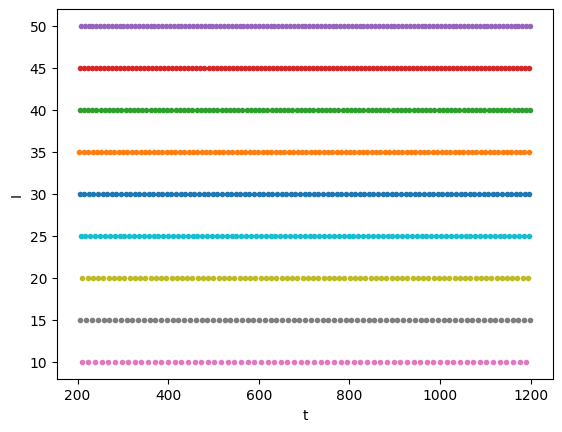

In [12]:
y0 = [-70, 0.1, 0.6, 0.4]    # initial state: V, m, h, n
tt = np.arange(0, 1200, 0.1) # integration time
Is = np.arange(-20, 51, 5)
Fs = []
for c, Ic in enumerate(Is):
    tf = ss_spikes(y0, tt, stim=Ic)
    plt.plot(tf, tf*0+Ic, '.')
    Fs.append(len(tf))
plt.xlabel("t")
plt.ylabel("I")

Text(0, 0.5, 'F (Hz)')

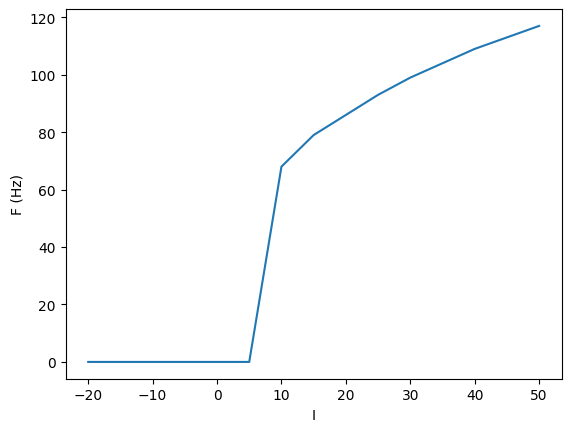

In [13]:
plt.plot(Is, Fs)
plt.xlabel("I")
plt.ylabel("F (Hz)")

Text(0, 0.5, 'F (Hz)')

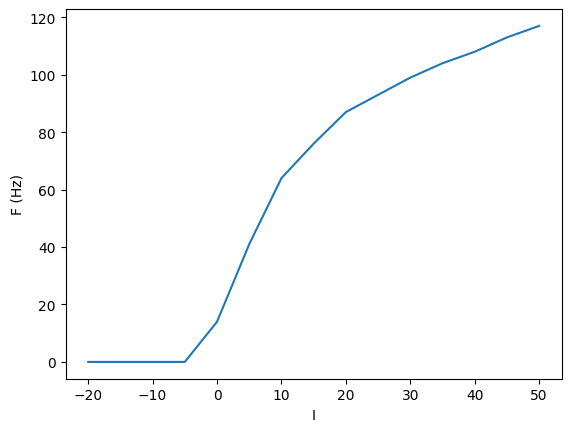

In [18]:
y0 = [-70, 0.1, 0.6, 0.4]    # initial state: V, m, h, n
tt = np.arange(0, 1200, 0.1) # integration time
In = 2  # noise size
noise = np.random.normal(0, 1, 1201)  # normal gaussian noise every 1ms
def Inoise(t):
    i = int(np.floor(t))
    return Ic + In*noise[i]
Fs = []
for c, Ic in enumerate(Is):
    tf = ss_spikes(y0, tt, stim=Inoise)
    Fs.append(len(tf))
plt.plot(Is, Fs)
plt.xlabel("I")
plt.ylabel("F (Hz)")

### 2. Network of IF neurons with simple pulse-connection instead of $\alpha$ function

In [ ]:
def alpha(t, tau_s=5): # integral = tau_s
    return t/tau_s*np.exp(-t/tau_s)
def delta(t): # integral = 1
    return 1 if t == 0 else 0

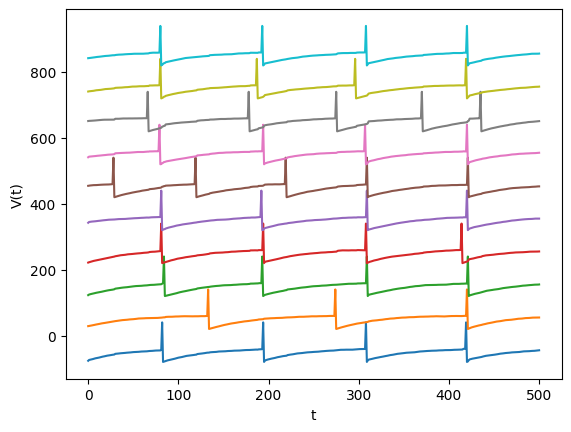

In [ ]:
# setup iaf network with delta synapses (i.e. only instantaneous currents)
N = 10    # number of neurons
tau = 50  # membrane time constant
V0 = -45  # resting potential
Vth = -40 # threshold
Vs = 40   # spike height
Vr = -80  # reset
W = 40    # connection weight size; assume exponential distribution
w = np.random.exponential(W, N**2).reshape((N,N))
for i in range(N):
    w[i,i] = 0  # remove self-connection

# integrate ode
p_noise = 0.5
w_noise = 15
t_end = 500
dt = 1
v = np.random.uniform(Vr, Vth, size=N)
T = np.arange(0.0, t_end+dt, dt)
V = np.zeros((len(T), N))
last_spk = np.random.uniform(0, 1, size=N) < 0.1 # random initial spikes
for ti, t in enumerate(T):
    # record voltage before possible reset/spike
    V[ti] = v
    # subthreshold dynamics
    epsp = w.dot(last_spk.astype(float)) + (np.random.rand(N) < p_noise) * w_noise
    dv = dt * (-v + V0 + epsp) / tau
    v += dv
    # check for spikes
    last_spk = v >= Vth
    if last_spk.any():
        V[ti, last_spk] = Vs # for plotting
        v[last_spk] = Vr # reset actual voltage

# much more quiescent than the alpha synapse model
plt.plot(T, V + np.arange(N)*100)  # shift traces vertically
plt.xlabel("t")
plt.ylabel("V(t)")

### 3. RNN simulation with different connection weights

### 4. State and weights evolution under STDP in RNNs